# N1904-TF wordform to morph dispersion

## Table of content (ToC)<a class="anchor" id="TOC"></a>
* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Setting up testing environment</a>
    * <a href="#bullet2x1">2.1 - Load N1904-TF</a>
    * <a href="#bullet2x2">2.2 - Load morphkit</a>
* <a href="#bullet3">3 - Run the tests</a>    
    * <a href="#bullet3x1">3.1 - Test decoding of some morph tags</a>
    * <a href="#bullet3x2">3.2 - Run  automated test with all morphs in the GNT</a>
* <a href="#bullet4">4 - Conclusion</a>
* <a href="#bullet5">5 - Attribution and footnotes</a>
* <a href="#bullet6">6 - Required libraries</a>
* <a href="#bullet7">7 - Notebook version</a>


# 1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This Jupyter Notebook ...

# 2 - Setting up testing environment <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

Here we load the required resources.

## 2.1 - Load N1904-TF with N1904Addons<a class="anchor" id="bullet2x1"></a>

We can just load the plain N1904-TF dataset.

In [ ]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

In [ ]:
# Import required modules, including Text-Fabric (tf)
from tf.app import use
import os
import sys

In [22]:
# Load the N1904-TF app and data 
A = use ("CenterBLC/N1904", version="1.0.0", mod="tonyjurg/N1904addons/tf", silence="terse", hoist=globals())

**Locating corpus resources ...**

   |     0.52s T formaltag            from ~/text-fabric-data/github/tonyjurg/N1904addons/tf/1.0.0
   |     0.52s T functionaltag        from ~/text-fabric-data/github/tonyjurg/N1904addons/tf/1.0.0


Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

# Calculate the dispersion

In [9]:
from collections import defaultdict
from tf.app import use
import pandas as pd
from tqdm import tqdm

# Step 1: Create a dictionary to collect all morph tags per unique wordform
# Key = wordform (in betacode), Value = set of unique morph tags found
formToMorphTags = defaultdict(set)

# Iterate through all word nodes in the dataset
for wordNode in tqdm(F.otype.s('word'),desc="Step1: obtain all betacode to morph data"):
    wordForm = F.betacode.v(wordNode)    # Get the word's betacode representation
    morphTag = F.morph.v(wordNode)       # Get the assigned morph tag

    # Add the morph tag to the set for this wordform, if both exist (usualy the case...)
    if wordForm and morphTag:
        formToMorphTags[wordForm].add(morphTag)

# Step 2: Prepare a list of dictionaries to populate a DataFrame
# Each row will contain the wordform, number of morph tags, and a string list of the tags
data = []

for wordForm, morphSet in tqdm(formToMorphTags.items(),desc="Step2: dispersion analysis"):
    data.append({
        'wordform': wordForm,
        'num_morph_tags': len(morphSet),            # Dispersion count
        'morph_tags': ', '.join(sorted(morphSet)),  # Comma-separated morph tag list
    })

# Step 3: Create a DataFrame from the data and sort by dispersion (descending)
df = pd.DataFrame(data)
df = df.sort_values(by='num_morph_tags', ascending=False)

# Display the resulting DataFrame
df


Step2: dispersion analysis: 100%|██████████| 19446/19446 [00:00<00:00, 1434443.12it/s]


,wordform,num_morph_tags,morph_tags
1462,e(autw=n,5,"F-1GPM, F-2GPM, F-3GPF, F-3GPM, F-3GPN"
5107,tina,4,"X-APN, X-ASF, X-ASM, X-NPN"
2938,ai)w/nion,4,"A-ASF, A-ASM, A-ASN, A-NSN"
871,prw=ton,4,"A-ASM-S, A-ASN-S, A-NSN-S, ADV-S"
4428,o)li/gon,4,"A-ASM, A-ASN, A-NSN, ADV"
...,...,...,...
49,*)abia/,1,N-PRI
50,*)abia\,1,N-PRI
51,*)asa/f,1,N-PRI
52,*)asa\f,1,N-PRI


## Histogram of total morph dispersion

Note this is for all words found in the GNT

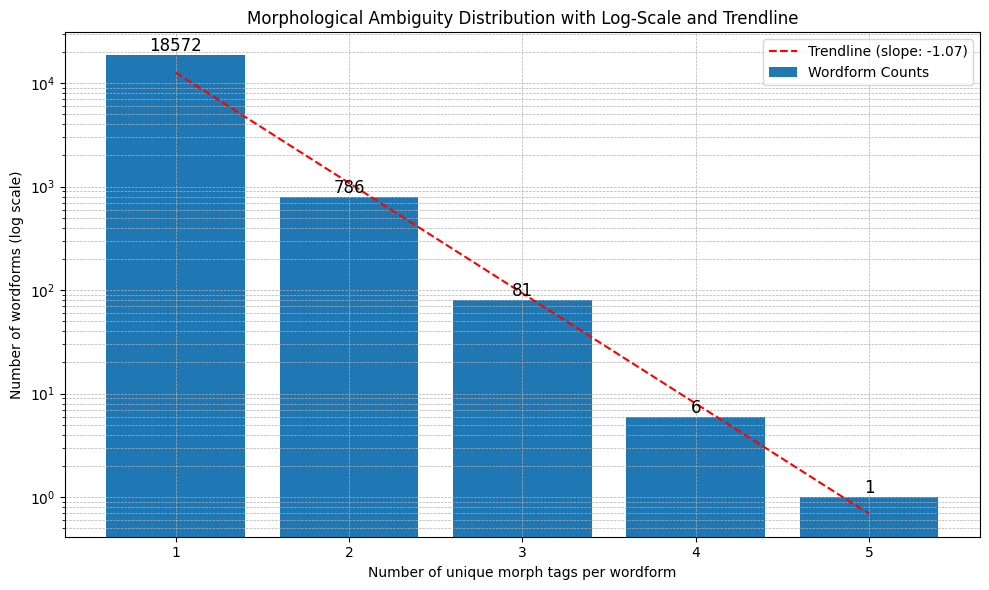

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Plot build using info from : https://labex.io/tutorials/python-logarithmic-bar-chart-48810

# Step 1: Count how many wordforms have a given number of morph tags (dispersion)
# e.g., how many wordforms have exactly 1 morph tag, 2 morph tags, etc.
dispersionCounts = Counter(len(mset) for mset in formToMorphTags.values())

# Step 2: Prepare x and y data for plotting
# x = number of morph tags (dispersion value)
# y = number of wordforms that have this level of dispersion
x = sorted(dispersionCounts)
y = [dispersionCounts[k] for k in x]

# Step 3: Convert to NumPy arrays for regression analysis
x_np = np.array(x)
y_np = np.array(y)
log_y = np.log10(y_np)    # Take log10 of y-values for log-space regression

# Step 4: Fit a linear regression to the log-transformed data
# This models y as an exponential decay function in log space
slope, intercept = np.polyfit(x_np, log_y, 1)

# Convert the regression line back to original y-scale (antilog)
trendline = 10 ** (slope * x_np + intercept)

# Step 5: Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, label='Wordform Counts')     # Bar plot of dispersion histogram

# Step 6: Add the exponential trendline to the plot
# see also https://www.statology.org/matplotlib-trendline
plt.plot(x, trendline, color='red', linestyle='--', label=f'Trendline (slope: {slope:.2f})')

# Step 7: Annotate each bar with its count
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,      # x position (center of the bar)
             height,                                 # y position (top of the bar)
             f'{y[i]}',                              # label text (count)
             ha='center', va='bottom', fontsize=12)  # alignment and font size

# Step 8: Configure plot appearance
plt.yscale('log')             # Set y-axis to log scale for better visibility of small bars
plt.xlabel('Number of unique morph tags per wordform')
plt.ylabel('Number of wordforms (log scale)')
plt.title('Morphological Ambiguity Distribution with Log-Scale and Trendline')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()           # Adjust layout to avoid clipping
plt.show()                   # Display the plot

##  Average Morph Dispersion

Now compute the average number of morph tags per wordform, which should be very close to 1, when looking at the previous plot. This is very simple since all data is already in a dataframe.

In [16]:
avg_dispersion = df['num_morph_tags'].mean()
print(f"Average morph tag dispersion per wordform: {avg_dispersion:.2f}")

Average morph tag dispersion per wordform: 1.05


##  Breakdown by Part of Speech

Maybe more interesting would be to split it over the Part of Speech values. Let's now extract the POS prefix from morph tags (e.g., ADV, A-, V-) and analyze which POS categories tend to show more variation.

In [17]:
posDispersion = defaultdict(list)

for wordForm, morphSet in formToMorphTags.items():
    posTags = {morph.split('-')[0] for morph in morphSet}
    for pos in posTags:
        posDispersion[pos].append(len(morphSet))

# Average dispersion by POS
posSummary = [(pos, sum(vals)/len(vals)) for pos, vals in posDispersion.items()]
posSummary.sort(key=lambda x: -x[1])

for pos, avg in posSummary:
    print(f"{pos}: average dispersion = {avg:.2f}")


X: average dispersion = 1.72
I: average dispersion = 1.68
C: average dispersion = 1.50
F: average dispersion = 1.41
T: average dispersion = 1.41
INJ: average dispersion = 1.38
R: average dispersion = 1.34
K: average dispersion = 1.31
S: average dispersion = 1.28
D: average dispersion = 1.20
P: average dispersion = 1.16
A: average dispersion = 1.15
PRT: average dispersion = 1.11
Q: average dispersion = 1.08
ADV: average dispersion = 1.08
PREP: average dispersion = 1.05
N: average dispersion = 1.05
V: average dispersion = 1.02
CONJ: average dispersion = 1.00
COND: average dispersion = 1.00
HEB: average dispersion = 1.00
ARAM: average dispersion = 1.00


Interesting... indeed there is a significant difference in dispersion per POS catagory. 

## plot the dispersion per POS

So let us now make a nice plot of this data. Here we visualize how part-of-speech (POS) categories diverge in their morphological dispersion.

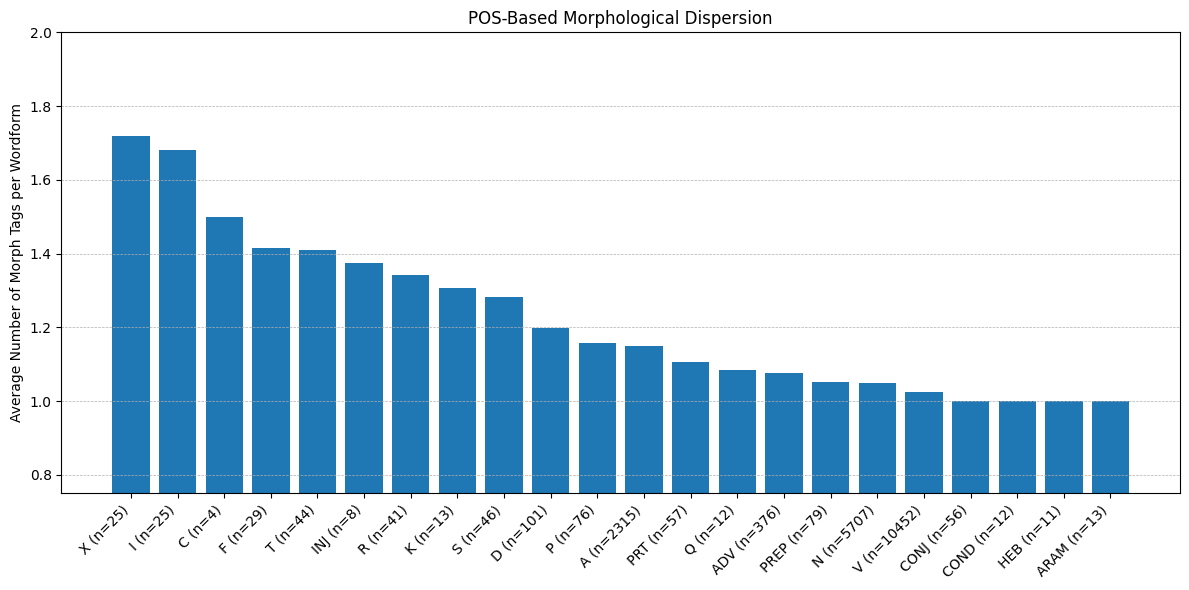

In [19]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Build a mapping from POS tags to lists of dispersion values
# posToDispersion: {POS → list of how many morph tags each wordform with that POS has}
posToDispersion = defaultdict(list)

for wordForm, morphSet in formToMorphTags.items():
    dispersion = len(morphSet)   # Number of distinct morph tags for this wordform

    # Extract POS tags from the morph tags (prefix before first dash, e.g., 'N', 'V', 'ADV') 
    # Note: if time permits, it may be also interesting to split out even further, like 'All Verbs'-> 'Verb', 'Participle', 'Infinitive'
    posSet = {m.split('-')[0] for m in morphSet if m}  # Extract POS prefix

    # Assign this dispersion value to all POS tags associated with this wordform
   for pos in posSet:
        posToDispersion[pos].append(dispersion)

# Step 2: Compute average dispersion for each POS
# Also record how many wordforms were associated with that POS
posSummary = [
    (pos, np.mean(dispersions), len(dispersions))
    for pos, dispersions in posToDispersion.items()
]

# Step 3: Sort the POS categories by average dispersion, highest to lowest
posSummary.sort(key=lambda x: -x[1])

# Step 4: Prepare labels and values for plotting
# posLabels: e.g., 'N (n=1223)' Adding the group size to the display is very relevant!
# avgDisp: average number of morph tags per wordform for that POS
posLabels = [f"{pos} (n={n})" for pos, _, n in posSummary]
avgDisp = [avg for _, avg, _ in posSummary]

# Step 5: Plot the bar chart
plt.figure(figsize=(12, 6))
plt.ylim(0.75, 2)   # Focus the y-axis on the range of interest
bars = plt.bar(posLabels, avgDisp)  # Plot bars

# Further customize plot appearance
plt.xticks(rotation=45, ha='right')   # Rotate x-axis labels for readability
plt.ylabel('Average Number of Morph Tags per Wordform')
plt.title('POS-Based Morphological Dispersion')
plt.grid(axis='y', linestyle='--', linewidth=0.5)   # Add gridlines to y-axis
plt.tight_layout()   # Automatically adjust layout to avoid label clipping
plt.show()   # Display the plot

# Import formal tag info from MACULA

Now I am going to recycle two TF features that were created from the GBI version of the MACULA dataset. This was part of [Nestle1904GBI](https://tonyjurg.github.io/Nestle1904GBI/). Since at word-node level this TF dataset is compatible with the N1904-TF dataset, I can just copy over the feature file to the N1904addons tf directory and reload TF with these features included.

The following two fwo features from the Nestle1904GBI TF dataset will be imported:
  - [formaltag](https://tonyjurg.github.io/Nestle1904GBI/features/formaltag.html)
  - [functionaltag](https://tonyjurg.github.io/Nestle1904GBI/features/functionaltag.html)

In [32]:
print(F.formaltag.v(1))

N-NSF


A quick check on deltas:

In [34]:
formtag, functag = 0, 0
for w in F.otype.s('word'):
    morph=F.morph.v(w)
    formaltag=F.formaltag.v(w)
    functionaltag=F.functionaltag.v(w)
    if morph!=formaltag: formtag+=1
    if morph!=functionaltag: functag+=1
print (f'formtag={formtag} functag={functag}')

formtag=2144 functag=0


Now dive a litle bit deeper:

In [36]:
from tqdm import tqdm

# List to collect differences
differences = []

# Iterate over all word nodes
for w in tqdm(F.otype.s('word'), desc="Comparing morph and formaltag"):
    morph = F.morph.v(w)
    formaltag = F.formaltag.v(w)

    # If tags differ, record the word node and tag values
    if morph != formaltag:
        differences.append({
            'word_node': w,
            'morph': morph,
            'formaltag': formaltag,
            'reference': T.sectionFromNode(w),
            'text': T.text(w),
        })

# Display as a pandas DataFrame
import pandas as pd
df_diff = pd.DataFrame(differences)
# Display the first few rows as a preview
print(df_diff.head(20))

Comparing morph and formaltag: 100%|██████████| 137779/137779 [00:00<00:00, 1271934.73it/s]

    word_node      morph  formaltag         reference               text
0         245  V-PPP-NSM  V-PEP-NSM  (Matthew, 1, 16)         λεγόμενος 
1         375  V-APP-NSN  V-AEP-NSN  (Matthew, 1, 22)             ῥηθὲν 
2         399  V-PPP-NSN  V-PEP-NSN  (Matthew, 1, 23)  μεθερμηνευόμενον 
3         503   V-PPS-3S   V-PES-3S   (Matthew, 2, 4)         γεννᾶται. 
4         514   V-RPI-3S   V-REI-3S   (Matthew, 2, 5)         γέγραπται 
5         722  V-APP-NSN  V-AEP-NSN  (Matthew, 2, 15)             ῥηθὲν 
6         775  V-APP-NSN  V-AEP-NSN  (Matthew, 2, 17)             ῥηθὲν 
7         829   V-RAI-3P   V-REI-3P  (Matthew, 2, 20)        τεθνήκασιν 
8         882  V-PPP-ASF  V-PEP-ASF  (Matthew, 2, 23)         λεγομένην 
9         887  V-APP-NSN  V-AEP-NSN  (Matthew, 2, 23)             ῥηθὲν 
10        921  V-APP-NSM  V-AEP-NSM   (Matthew, 3, 3)            ῥηθεὶς 
11        984   V-IPI-3P   V-IEI-3P   (Matthew, 3, 6)       ἐβαπτίζοντο 
12        991  V-PMP-NPM  V-PEP-NPM   (Matthew, 3, 

Just to be sure on the POS types where there are differences:

In [38]:
# Extract POS part (prefix before '-') from both columns
df_diff['morph_pos'] = df_diff['morph'].str.split('-').str[0]
df_diff['formaltag_pos'] = df_diff['formaltag'].str.split('-').str[0]

# Count frequencies
morph_pos_counts = df_diff['morph_pos'].value_counts()
formaltag_pos_counts = df_diff['formaltag_pos'].value_counts()

# Display the results
print("POS frequency from morph:")
print(morph_pos_counts)

print("\nPOS frequency from formaltag:")
print(formaltag_pos_counts)

POS frequency from morph:
morph_pos
V    2144
Name: count, dtype: int64

POS frequency from formaltag:
formaltag_pos
V    2144
Name: count, dtype: int64


Indeed this confirms the comments on [github.com/biblicalhumanities](https://github.com/biblicalhumanities/Nestle1904/tree/master/morph#morphological-analysis):

> Two morphological tags are provided: One which is more "functional", and one which is more "form-oriented". The differences between the two only exist in the description of the verbal system. The form-oriented system is very careful not to make morphological distinctions which are not warranted by the form. For example, the present indicative does not exhibit any formal characteristics which allows the distinction between the middle and the passive voice, hence present indicative verbs are always described as being middle/passive in the "form-oriented" tag. The "functional" tag, on the other hand, sometimes makes a distinction between the middle and the passive, even in the tenses where this is not formally distinguished by the forms. This is so as to be sensitive to the semantics of the verb.
                                                                     

It can be concluded that the feature values for [`morph` in N1904-TF](https://centerblc.github.io/N1904/features/morph.html) and [`functionaltag` in Nestle 1904 GNT](https://tonyjurg.github.io/Nestle1904GBI/features/functionaltag.html) are identical. For that reason I will only add the feature [`formaltag` from Nestle1904GBI](https://tonyjurg.github.io/Nestle1904GBI/features/formaltag.html) to the set [N1904addons](https://tonyjurg.github.io/N1904addons/).